# Improving Heart Disease Risk Predictions with Domain-Adversarial Networks and Ensemble Optimization

#### Trustworthy AI Examples Series

This notebook addresses demographic distribution shifts in cardiac risk models. Using the Heart Disease dataset, it presents a robust clinical decision pipeline that incorporates domain-adversarial representation learning, dynamic test-time normalization, and ensemble-based uncertainty quantification to ensure consistent performance across diverse patient subgroups.

Models trained on one population mix can lose reliability when deployed on another because feature statistics and measurement conditions change. These shifts can erode confidence even when cross-validation looks strong. To address this, the notebook simulates realistic covariate and demographic shifts, runs stress tests on shifted splits, and evaluates robustness using metrics such as shifted accuracy, ROC AUC, and predictive uncertainty under shift.

Through this scenario, readers will:

1. **Understand the real-world stakes**: how and why standard validation can overestimate real-world performance.
2. **Learn to construct end-to-end AI pipelines**: from domain-adversarial training to ensemble prediction.
3. **Apply robustness strategies in-context**: including DTN, ensembling, and output-level adjustments to preserve robustness and manage uncertainty under realistic deployment shifts.

In [25]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import python.utils.preprocessing as pp

### Set Manual Seed

Setting seeds for random operations allows for reproducible results, which are used within this notebook.

In [27]:
np.random.seed(42)
torch.manual_seed(42)

## Data Preparation

In order to train a model on the Heart Disease dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training. In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

To prepare the dataset for modeling, first transform categorical variables using ordinal encoding, excluding the target to preserve interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms. The `split_data` splits the data for model training and evaluation.

As seen in the visualization, the training set is roughly balanced along the age median split (124 vs. 119), but real-world clinics can have different patient mixes, so the pipeline intentionally simulates a deployment shift to test robustness.

Domain label counts:
age
old      124
young    119
Name: count, dtype: int64


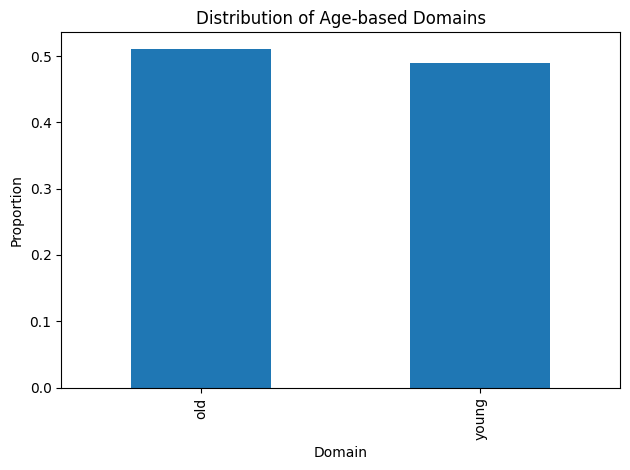

In [28]:
file_path = PROJECT_ROOT / 'data/heart_disease.csv'
df = pp.load_data(file_path)
df = pp.handle_missing_values(df, strategy='median')

target_col = 'target'

df_enc = pp.encode_categorical_data(df, method='ordinal', exclude_cols=[target_col])
df_scaled = pp.scale_features(df_enc, method='standardize', exclude_cols=[target_col])

X_train, X_test, y_train, y_test = pp.split_data(df_scaled, target_col=target_col, test_size=0.2)

domain_labels = X_train['age'].apply(lambda x: 'young' if x < X_train['age'].median() else 'old')

print("Domain label counts:")
print(domain_labels.value_counts())

domain_labels.value_counts(normalize=True).plot(kind='bar')
plt.title("Distribution of Age-based Domains")
plt.xlabel("Domain")
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()

## Simulate Demographic Shifts

To simulate demographic shifts, a seeded resampling routine is used to create a test set with 70% older and 30% younger patients. The bar plot below shows the distribution along the age median before and after, which verifies the change and lets the pipeline meaningfully stress-test robustness interventions under a plausible population shift. The resampling is reproducible thanks to the fixed seed, though one should note that sampling with replacement can duplicate records and slightly alter within-group class balances.

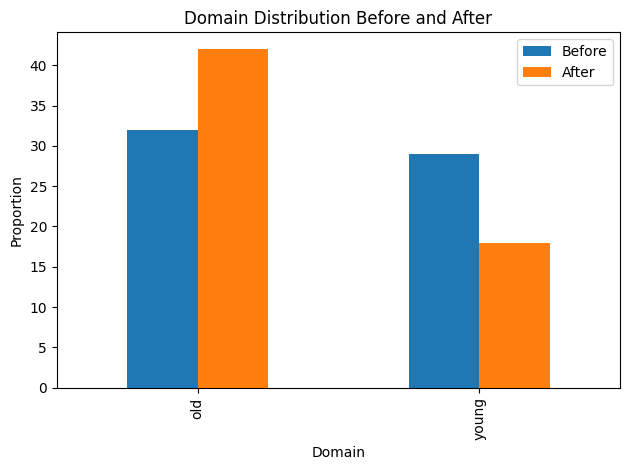

In [29]:
def resample_by_group(X, y, group_labels, target_dist):
    np.random.seed(42)
    dfs = []
    n = len(y)
    for g, frac in target_dist.items():
        idx = np.where(group_labels == g)[0]
        k = int(frac * n)
        chosen = np.random.choice(idx, size=k, replace=True)
        df_part = pd.DataFrame(X.values[chosen], columns=X.columns)
        df_part['y_true'] = y.values[chosen]
        df_part['group'] = group_labels[chosen]
        dfs.append(df_part)
    return pd.concat(dfs).reset_index(drop=True)

domain_test = X_test['age'].apply(lambda x: 'young' if x < X_test['age'].median() else 'old')
shifted_test = resample_by_group(X_test, y_test, domain_test.values, {'young': 0.3, 'old': 0.7})

shifted_labels = shifted_test['group']
X_test_shifted, y_test_shifted = shifted_test[X_test.columns], shifted_test['y_true']

dist_df = pd.DataFrame({'Before': domain_test.value_counts(), 'After': shifted_labels.value_counts()}).sort_index()

dist_df.plot(kind='bar')
plt.title("Domain Distribution Before and After")
plt.xlabel("Domain")
plt.ylabel("Proportion")
plt.legend()
plt.tight_layout()
plt.show()

## Baseline Multilayer Perceptron

To accurately access the effect of robustness techniques, a small baseline multilayer perceptron is implemented with one hidden layer of 64 units, ReLU activation, and a 50% dropout layer for regularization. The final layer produces a single sigmoid output interpreted as the predicted probability of heart disease diagnosis. The architecture is intentionally compact so that gains from domain adaptation, ensembling, and test-time tricks can be attributed to those methods rather than model capacity.

In [30]:
class DropoutBinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.label_predictor = nn.Linear(64, 1)

    def forward(self, x):
        features = self.feature_extractor(x)
        label_output = torch.sigmoid(self.label_predictor(features))
        return label_output

### Training Function

The training routine runs standard supervised optimization with the Adam optimizer and binary cross-entropy loss. Inputs and targets are converted to PyTorch tensors and loaded into a DataLoader with batch shuffling; the model is trained for 50 epochs and updates weights by backpropagation on each batch. This function is intended for reproducible, repeatable training with minimal bells and whistles so the baseline performance reflects straightforward learning on the preprocessed features.

In [31]:
def train_baseline(model, X, y, epochs=50, lr=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)

    train_dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    for _ in range(epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            y_pred = model(batch_X)
            loss = loss_fn(y_pred, batch_y)
            loss.backward()
            optimizer.step()
    return model

baseline_model = train_baseline(DropoutBinaryMLP(input_dim=X_train.shape[1]), X_train, y_train)

### Model Evaluation

The trained model is evaluated with accuracy and ROC AUC for discrimination alongside mean predictive entropy to characterize per-sample confidence. Predictive entropy is used here as a easily interpretable measure of how confident the model’s probability estimates are (higher entropy = less confident).

The baseline achieves an accuracy of 76.7%, ROC AUC of 0.835, and mean predictive entropy of 0.343. Although the model has clearly learned some patterns from the dataset, the performance is overall nominal and leaves significant room for improvement. Such a model would be neither viable nor safe for healthcare applications in its current state.

In [32]:
def predictive_entropy(probs, eps=1e-10):
    probs = np.clip(probs, eps, 1 - eps)
    entropy = -probs * np.log(probs) - (1 - probs) * np.log(1 - probs)
    return entropy

X_test_tensor = torch.tensor(X_test_shifted.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_shifted.values, dtype=torch.float32)

baseline_model.eval()
with torch.no_grad():
    y_pred_probs = baseline_model(X_test_tensor).numpy()
    y_pred_labels = (y_pred_probs >= 0.5).astype(int)

y_true = y_test_tensor.numpy()

acc = accuracy_score(y_true, y_pred_labels)
auc = roc_auc_score(y_true, y_pred_probs)
ent = predictive_entropy([y_pred_probs])

print("=== Baseline Model ===")
print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC Score: {auc:.3f}")
print(f"Mean Predictive Entropy: {ent.mean():.3f}")

=== Baseline Model ===
Accuracy: 0.767
ROC AUC Score: 0.835
Mean Predictive Entropy: 0.343


## Domain-Adversarial Neural Network

To address the robustness concerns raised by the baseline model, a Domain-Adversarial Neural Network (DANN) is designed to learn features that are predictive of the label but invariant to domain, age group. The model shares the same feature extractor backbone as the baseline but adds a domain classifier head and a Gradient Reversal Layer (GRL). During the forward/backward pass the GRL inverts domain-gradient signals, encouraging the feature extractor to remove domain-specific cues. In effect, the network is trained to perform the label task while simultaneously avoiding reliance on the domain, which promotes domain-invariant representations useful under distribution shift.

In [33]:
class GRL(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class DANN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.label_predictor = nn.Linear(64, 1)
        self.domain_classifier = nn.Linear(64, 2)

    def forward(self, x, lambda_=1.0):
        features = self.feature_extractor(x)
        reverse_features = GRL.apply(features, lambda_)
        label_output = torch.sigmoid(self.label_predictor(features))
        domain_output = self.domain_classifier(reverse_features)
        return label_output, domain_output

dann = DANN(input_dim=X_train.shape[1])

### Training Function

DANN training jointly optimizes two objectives: standard label loss and a domain classification loss. Each minibatch supplies features, labels, and domain indicators; the optimizer updates weights to reduce label loss while the GRL causes the feature extractor to maximize domain loss. This adversarial setup requires careful batching and balancing of losses but is implemented here with the same optimizer and data pipeline used for the baseline so results are directly comparable.

In [34]:
def train_dann(model, X, y, domain_labels, epochs=50, lr=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_label = nn.BCELoss()
    loss_domain = nn.BCEWithLogitsLoss()

    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)
    domain_tensor = torch.tensor(pd.get_dummies(domain_labels).values, dtype=torch.float32)

    train_dataset = TensorDataset(X_tensor, y_tensor, domain_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    for _ in range(epochs):
        for batch_X, batch_y, batch_d in train_loader:
            optimizer.zero_grad()
            y_pred, d_pred = model(batch_X, lambda_=1.0)
            loss = loss_label(y_pred, batch_y) + loss_domain(d_pred, batch_d)
            loss.backward()
            optimizer.step()
    return model

dann_model = train_dann(DANN(input_dim=X_train.shape[1]), X_train, y_train, domain_labels)

### Model Evaluation

The trained model is evaluated with accuracy and ROC AUC for discrimination alongside mean predictive entropy to characterize per-sample confidence. Predictive entropy is used here as a easily interpretable measure of how confident the model’s probability estimates are (higher entropy = less confident).

The DANN achieves an accuracy of 76.7%, ROC AUC of 0.845, and mean predictive entropy of 0.360. This pattern suggests the adversarial objective helped the model learn features that better separate positives from negatives under the simulated domain condition but did so by moderately increasing the uncertainty (entropy) in its predictions. This is likely caused by the network suppressing domain-specific cues and relying on more domain-invariant signals. In practice, this is a desirable robustness signal, as DANN appears to generalize better across age domains. However, the change is modest and does not by itself make the model safe for clinical deployment.

In [35]:
dann_model.eval()
with torch.no_grad():
    y_pred_probs_dann, _ = dann_model(X_test_tensor)
    y_pred_probs_dann = y_pred_probs_dann.numpy()
    y_pred_labels_dann = (y_pred_probs >= 0.5).astype(int)

y_true = y_test_tensor.numpy()

acc_dan = accuracy_score(y_true, y_pred_labels_dann)
auc_dan = roc_auc_score(y_true, y_pred_probs_dann)
ent_dan = predictive_entropy([y_pred_probs_dann])


print("=== DANN Model ===")
print(f"Accuracy: {acc_dan:.3f}")
print(f"ROC AUC Score: {auc_dan:.3f}")
print(f"Mean Predictive Entropy: {ent_dan.mean():.3f}")

=== DANN Model ===
Accuracy: 0.767
ROC AUC Score: 0.845
Mean Predictive Entropy: 0.360


## DANN Ensemble

The next logical step for increasing performance is to combine DANN with model-level robustness through ensembling. An ensemble of DANN models will theoretically increase robustness and stabilize predictions. The `train_ensemble` routine instantiates multiple DANNs using different fixed seeds (so each model’s initialization and training order are reproducible), trains each one with the same adversarial procedure, and collects the trained members into a list. Ensembling in this manner aims to average out idiosyncratic errors of single runs and to provide a simple way to quantify model disagreement via cross-model variation.

In [36]:
def train_ensemble(X, y, domain_labels, n_models=5):
    ensemble = []
    for seed in range(n_models):
        torch.manual_seed(42 + seed)
        model = DANN(input_dim=X.shape[1])
        trained_model = train_dann(model, X, y, domain_labels)
        ensemble.append(trained_model)
    return ensemble

def ensemble_predict(models, X):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    preds = []
    for model in models:
        model.eval()
        with torch.no_grad():
            y_pred, _ = model(X_tensor)
            preds.append(y_pred.numpy())
    preds = np.array(preds)
    mean_preds = preds.mean(axis=0)
    uncertainty = preds.std(axis=0)
    return mean_preds, uncertainty

ensemble_models = train_ensemble(X_train, y_train, domain_labels)

### Ensemble Evaluation

The `ensemble_predict` function runs every ensemble member on the same inputs, stacks their probability outputs, and returns both the ensemble mean prediction and the per-example standard deviation as an uncertainty proxy.

The DANN ensemble achieves an accuracy of 81.7%, ROC AUC of 0.849 and mean predictive entropy of 0.373. Averaging multiple adversarial models improved raw decision accuracy and marginally improved ranking (AUC) relative to the single DANN, indicating that ensembling is successfully reducing idiosyncratic errors from individual training runs and strengthening overall discrimination. At the same time, mean predictive entropy increased; this means that the ensemble’s average probability estimates are somewhat less confident on a per-sample basis, likely because the ensemble average smooths individual model extremes and exposes more borderline cases. Operationally, the ensemble represents a clear set up in robustness, but the rise in per-sample uncertainty will need to be addressed soon.

In [37]:
mean_preds, uncertainty = ensemble_predict(ensemble_models, X_test_shifted)
y_pred_labels_ens = (mean_preds >= 0.5).astype(int)

acc_ens = accuracy_score(y_test_shifted, y_pred_labels_ens)
auc_ens = roc_auc_score(y_test_shifted, mean_preds)
ent_ens = predictive_entropy(mean_preds)

print("=== DANN Ensemble ===")
print(f"Accuracy: {acc_ens:.3f}")
print(f"ROC AUC Score: {auc_ens:.3f}")
print(f"Mean Predictive Entropy: {ent_ens.mean():.3f}")

=== DANN Ensemble ===
Accuracy: 0.817
ROC AUC Score: 0.849
Mean Predictive Entropy: 0.373


## Dynamic Test-Time Normalization

Dynamic test-time normalization (DTN) is a post-processing robustness technique used to mitigate covariate shift at inference. The `dynamic_normalize` function re-centers and rescales test features using statistics computed from the incoming test set itself, rather than relying on training statistics. DTN is a lightweight, deployment-friendly adaptation that can reduce distribution mismatch between training and deployment inputs and thereby recover performance when feature means/variances change in the field.

In [38]:
def dynamic_normalize(X):
    return (X - X.mean()) / X.std()

X_test_dyn = dynamic_normalize(X_test_shifted)

### DTN Evaluation

After applying DTN to the shifted test split, the pipeline re-runs the ensemble to measure its new performance metrics.

The DANN ensemble with DTN achieves an accuracy of 86.7%, ROC AUC of 0.874 and mean predictive entropy of 0.402. Applying dynamic test-time normalization produced the largest gains in both accuracy and AUC by adapting feature statistics to the shifted test distribution, solidifying DTN’s value as a great lightweight, deployment-time robustness fix. However, DTN also raised mean entropy further, indicating more uncertain per-case probabilities despite stronger aggregate performance. This is a common trade-off when adapting to a new input distribution, because feature re-centering can expose cases that are genuinely harder to classify. Now that overall performance is sufficient, mean predictive uncertainty needs to be addressed.

In [39]:
mean_preds_dyn, uncertainty_dyn = ensemble_predict(ensemble_models, X_test_dyn)
y_pred_labels_dyn = (mean_preds_dyn >= 0.5).astype(int)

acc_dyn = accuracy_score(y_test_shifted, y_pred_labels_dyn)
auc_dyn = roc_auc_score(y_test_shifted, mean_preds_dyn)
ent_dyn = predictive_entropy(mean_preds_dyn)

print("=== DTN + DANN Ensemble ===")
print(f"Accuracy: {acc_dyn:.3f}")
print(f"ROC AUC Score: {auc_dyn:.3f}")
print(f"Mean Predictive Uncertainty: {ent_dyn.mean():.3f}")

=== DTN + DANN Ensemble ===
Accuracy: 0.867
ROC AUC Score: 0.874
Mean Predictive Uncertainty: 0.402


## Confidence Sharpening

Confidence sharpening is a simple, interpretable output-level adjustment that makes probabilistic predictions more decisive without retraining. The `sharpen_predictions` transform raises probabilities to a power (`gamma>1`) and renormalizes, which moves values away from 0.5 toward 0 or 1.

In [40]:
def sharpen_predictions(probs, gamma=1.5, eps=1e-10):
    probs = np.clip(probs, eps, 1 - eps)
    sharp = probs**gamma / (probs**gamma + (1 - probs)**gamma)
    
    return sharp

### Model Evaluation

The DANN ensemble with DTN and confidence sharpening achieves an accuracy of 86.7%, ROC AUC of 0.874 and mean predictive entropy of 0.289. Sharpening predictions recovered decisiveness lost after adaptation by pushing probabilities away from 0.5, producing firmer, more actionable predictions. In addition, no loss in aggregate performance was witnessed, clearly positioning confidence sharpening as an attractive, low-cost post-hoc fix for workflows that need clearer automated decisions.

However, sharpening can lead to overconfidence risk, so it should be validated on a held-out shifted validation set and combined with monitoring. For long-term operational robustness, consider stronger measures like distillation or targeted retraining if misclassifications persist among high-uncertainty cases.

In [41]:
probs_sharp = sharpen_predictions(mean_preds_dyn, gamma=1.5)
y_pred_labels_sharp = (probs_sharp >= 0.5).astype(int)

acc_shp = accuracy_score(y_test_shifted, y_pred_labels_sharp)
auc_shp = roc_auc_score(y_test_shifted, probs_sharp)
ent_shp = predictive_entropy(probs_sharp)

print("=== Confidence-Sharpened DTN + Ensemble ===")
print(f"Accuracy: {acc_shp:.3f}")
print(f"ROC AUC Score: {auc_shp:.3f}")
print(f"Mean Predictive Entropy: {ent_shp.mean():.3f}")

=== Confidence-Sharpened DTN + Ensemble ===
Accuracy: 0.867
ROC AUC Score: 0.874
Mean Predictive Entropy: 0.289


## Model Comparison

### Accuracy Plot

The accuracy bar chart shows steady improvement as more advanced methods are applied. The baseline and single DANN both achieve 0.767, the DANN Ensemble rises to 0.817, and the DTN + DANN Ensemble reaches 0.867, an absolute gain of 0.10 over the baseline. This confirms that domain adaptation combined with ensembling and DTN to address the test shift improves decision correctness on the shifted test distribution. Importantly, the final confidence-sharpened variant preserves the top accuracy, demonstrating that output uncertainty can be reduced without sacrificing raw accuracy.

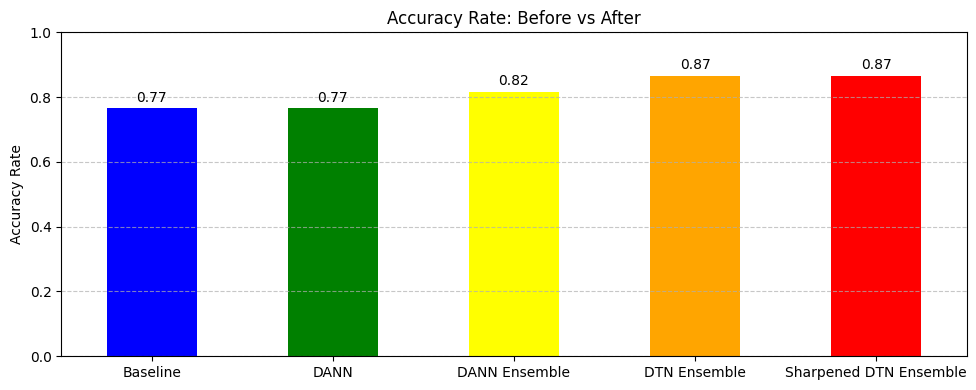

In [42]:
accuracy_comparison = pd.DataFrame({
    'Accuracy Rate': [acc, acc_dan, acc_ens, acc_dyn, acc_shp]
}, index=['Baseline', 'DANN', 'DANN Ensemble', 'DTN Ensemble', 'Sharpened DTN Ensemble'])

colors = ['blue', 'green', 'yellow', 'orange', 'red']
accuracy_series = accuracy_comparison['Accuracy Rate']

ax = accuracy_series.plot(kind='bar', figsize=(10, 4), color=colors)
plt.ylabel('Accuracy Rate'); plt.title('Accuracy Rate: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(accuracy_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### ROC AUC Plot

The ROC AUC bar chart reflects the accuracy trend, as AUC increases from 0.835 to 0.845 from DANN, then to 0.849 for the ensemble, and finally to 0.874 with DTN (unchanged after sharpening). Larger AUC indicates improved separation of positives and negatives under shift, and the unchanged AUC after sharpening indicates that confidence sharpening does not degrade the model’s ability to rank cases by risk.

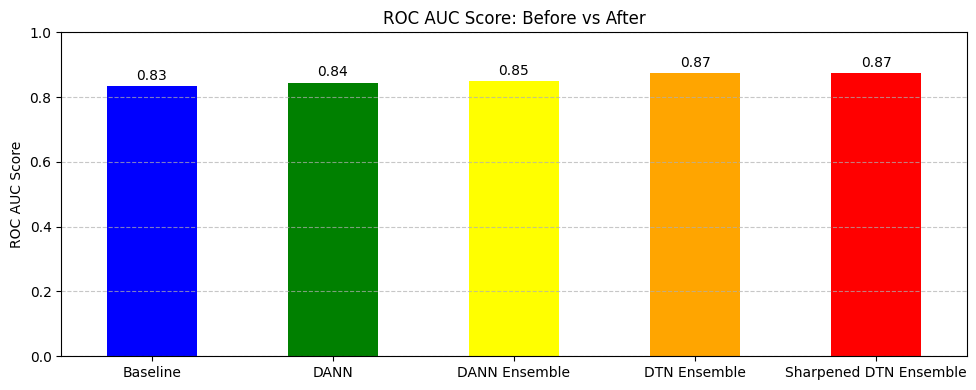

In [43]:
roc_auc_comparison = pd.DataFrame({
    'ROC AUC Score': [auc, auc_dan, auc_ens, auc_dyn, auc_shp]
}, index=['Baseline', 'DANN', 'DANN Ensemble', 'DTN Ensemble', 'Sharpened DTN Ensemble'])

colors = ['blue', 'green', 'yellow', 'orange', 'red']
roc_auc_series = roc_auc_comparison['ROC AUC Score']

ax = roc_auc_series.plot(kind='bar', figsize=(10, 4), color=colors)
plt.ylabel('ROC AUC Score'); plt.title('ROC AUC Score: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(roc_auc_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### Predictive Entropy Plot

The entropy bar chart reveals a different pattern than accuracy: entropy rises slightly from 0.343 (baseline) to 0.360 (DANN) and then 0.373 (DANN Ensemble), finally peaking at 0.402 for DTN + Ensemble, indicating that individual predictions are less confident under the shifted inputs even as performance improves. Crucially, the confidence-sharpened DTN + Ensemble reduces mean entropy to 0.289, demonstrating that the sharpening step restores decisiveness (lowering entropy) while retaining DTN’s accuracy and AUC improvements.

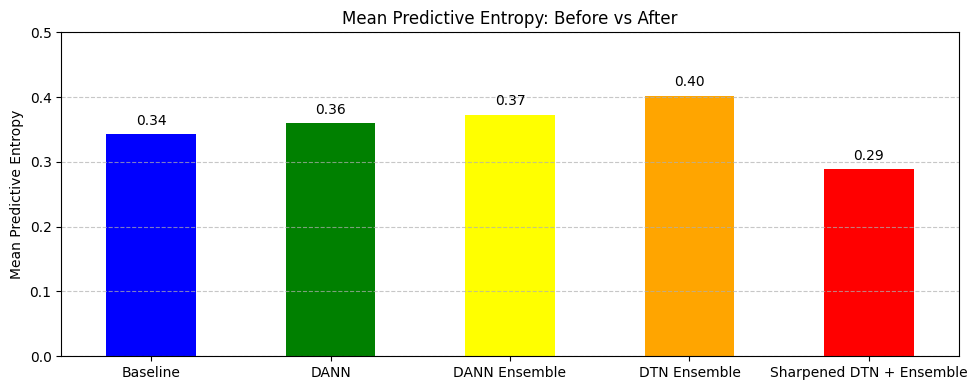

In [44]:
entropy_comparison = pd.DataFrame({
    'Mean Predictive Entropy': [ent.mean(), ent_dan.mean(), ent_ens.mean(), ent_dyn.mean(), ent_shp.mean()]
}, index=['Baseline', 'DANN', 'DANN Ensemble', 'DTN Ensemble', 'Sharpened DTN + Ensemble'])

colors = ['blue', 'green', 'yellow', 'orange', 'red']
entropy_series = entropy_comparison['Mean Predictive Entropy']

ax = entropy_series.plot(kind='bar', figsize=(10, 4), color=colors)
plt.ylabel('Mean Predictive Entropy'); plt.title('Mean Predictive Entropy: Before vs After'); plt.ylim(0, 0.5); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(entropy_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

## Final Model Results

### ROC Curve

The ROC curve for the final (sharpened DTN + ensemble) model bows strongly toward the top-left corner, with AUC = 0.874, and lies well above the diagonal random-guess line. This visually confirms robust discriminative power on the shifted test set: the model attains high true positive rates at low false positive rates, which is particularly valuable in risk-sensitive domains where avoiding false negatives is important.

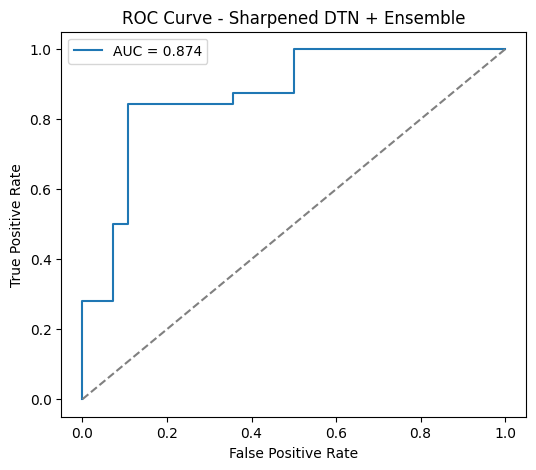

In [45]:
fpr, tpr, _ = roc_curve(y_test_shifted, probs_sharp)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_shp:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Sharpened DTN + Ensemble")
plt.legend()
plt.show()

### Confusion Matrix

According to the confusion matrix below, only 3 false positives and 5 false negatives were observed on the test set, indicating both classes are handled effectively. In a deployment interpretation, the low false-positive count would reduce unnecessary interventions while the modest false-negative count implies relatively few missed cases; together these counts corroborate the high accuracy/AUC and indicate that the sharpened model makes accurate and generalized predictions.

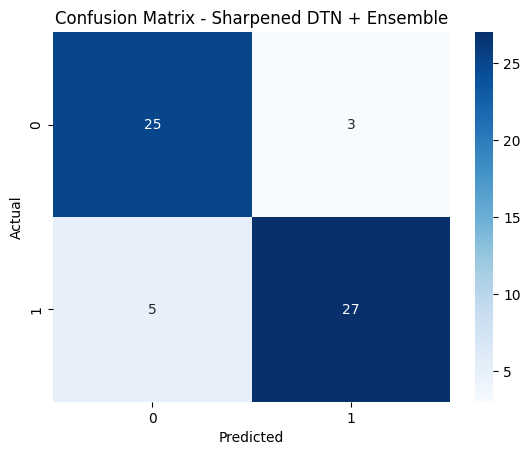

In [46]:
cm = confusion_matrix(y_test_shifted, y_pred_labels_sharp)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Sharpened DTN + Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Uncertainty Distribution

The uncertainty histogram is heavily skewed toward low uncertainty values (0.00–0.055) with a small tail and a single notable outlier near ~0.095, indicating that most predictions exhibit low ensemble disagreement while a few difficult cases result in variance. This behavior is useful for safety-critical applications like a medical triage workflow: most inputs could be auto-processed by the model, while the small set of higher-uncertainty outliers could be routed for human review or additional diagnostics.

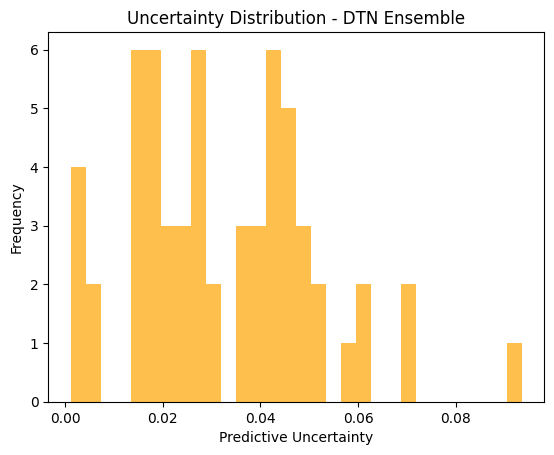

In [47]:
plt.hist(uncertainty_dyn, bins=30, alpha=0.7, color='orange')
plt.xlabel("Predictive Uncertainty")
plt.ylabel("Frequency")
plt.title("Uncertainty Distribution - DTN Ensemble")
plt.show()

## Case Study

The three case studies show that the DTN + ensemble with confidence sharpening makes mostly confident, correct calls but still misses some hard positives. Two examples, samples 0 and 9, were confidently negative and correct, while one true positive (sample 25) was scored negative with a high uncertainty.

From an operational standpoint, a diagnostic system should automatically accept clear, confident predictions and route the small number of uncertain or borderline cases to human review so the system stays safe and reliable. In practice, predictions that are far from 0.5 with low entropy and high ensemble confidence will generally not require human oversight, but cases with higher-than-average entropy or low ensemble confidence should be flagged for inspection to avoid the possibility of false negatives.

In [48]:
sample_idxs = [0, 9, 25]

for sample_idx in sample_idxs:
    sample = X_test_dyn.iloc[[sample_idx]]

    mean_pred_sample, unc_sample = ensemble_predict(ensemble_models, sample)
    sharp_pred_sample = sharpen_predictions(mean_pred_sample, gamma=1.5)
    entropy_sample = predictive_entropy(sharp_pred_sample)

    print(f"\n=== Data Sample {sample_idx + 1} ===")
    print(f"Sample Index: {sample_idx}")
    print(f"True Label: {y_test_shifted.iloc[sample_idx]}")
    print(f"Raw Ensemble Prediction: {mean_pred_sample[0].mean():.4f}")
    print(f"Sharpened Prediction: {sharp_pred_sample[0].mean():.4f}")
    print(f"Entropy: {entropy_sample[0].mean():.4f}")
    print(f"Uncertainty: {unc_sample[0].mean():.4f}")

    if sharp_pred_sample[0] >= 0.5:
        print("Model Decision: 1 → POSITIVE class (has heart disease)")
    else:
        print("Model Decision: 0 → NEGATIVE class (does not have heart disease)")


=== Data Sample 1 ===
Sample Index: 0
True Label: 0
Raw Ensemble Prediction: 0.1097
Sharpened Prediction: 0.0414
Entropy: 0.1725
Uncertainty: 0.0198
Model Decision: 0 → NEGATIVE class (does not have heart disease)

=== Data Sample 10 ===
Sample Index: 9
True Label: 0
Raw Ensemble Prediction: 0.0335
Sharpened Prediction: 0.0064
Entropy: 0.0388
Uncertainty: 0.0039
Model Decision: 0 → NEGATIVE class (does not have heart disease)

=== Data Sample 26 ===
Sample Index: 25
True Label: 1
Raw Ensemble Prediction: 0.1792
Sharpened Prediction: 0.0925
Entropy: 0.3084
Uncertainty: 0.0466
Model Decision: 0 → NEGATIVE class (does not have heart disease)


## Takeaways

This notebook exemplifies the importance of adapting predictive models to changing real-world conditions. By combining domain-adversarial learning, dynamic normalization, and post-processing techniques like confidence sharpening, the model maintained strong performance when tested on shifted populations.

These results directly connect technical choices to patient outcomes. Evidently, improving model robustness to shifted populations reduces missed or delayed diagnoses for groups that differ from the training mix, which can translate into earlier treatment and overall stronger prevention pipelines. Operationally, the findings affect how healthcare systems can deploy automated risk tools that best serve diverse patient populations. A model that preserves accuracy under distributional change but also flags high-uncertainty predictions enables human oversight efficiently, which improves throughput without sacrificing safety.

Models that are robust to realistic shifts are more defensible to regulators and stakeholders because they demonstrate attention to generalizability and ongoing reliability. By outlining a balance between automation and human review, healthcare professionals can take a practical path toward deploying AI systems that remain both accurate and trustworthy in evolving clinical settings.